In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

In [2]:
def hyperboloid():
    stpt = .25;#-.9-0.5

    stepsz = .125/6;
    endpt = 2.875/4-stepsz/2;#-1.275;%-.9+0.5
    endpt

    (endpt-stpt)//stepsz


    numpts = 30
    maxp = 1.5
    # nx, ny, nz = (numpts, numpts, numpts)
    xl = np.linspace(stpt, endpt, 1+int((endpt-stpt)//stepsz))
    yl = np.linspace(stpt, endpt, 1+int((endpt-stpt)//stepsz))
    # zl = np.linspace(0, endpt, numpts)

    xv, yv = np.meshgrid(xl, yl)

    # xvt, yvt = np.meshgrid(yl, xl)

    xli = np.linspace(1, int((endpt-stpt)//stepsz),dtype='int')
    yli = np.linspace(1, int((endpt-stpt)//stepsz),dtype='int')
    # zl = np.linspace(0, endpt, numpts)

    xvind, yvind = np.meshgrid(xli, yli)

#     max(xvind.flatten())

#     xv[-1,-1]

    # w = sqrt(.2*(-1 + (x(1).^2/.1 + x(2).^2/.1)));

#     zv = np.sqrt(.2*((np.power(xv.flatten(),2))/.1 + (np.power(yv.flatten(),2))/.1- 1))
    zv = np.sqrt(.2*((np.power(xv,2))/.1 + (np.power(yv,2))/.1- 1))
    
    return xv,yv,zv

In [3]:
def grad_hess(xv,yv,zv):
    
    ygrad = np.zeros(np.shape(xv)+(2,))
    yhess = np.zeros(np.shape(xv)+(4,))
    # for xi,xvi in enumerate(xv.flatten()[:]):
    # #     for yi,yvi in enumerate(yv.flatten()[:]):


    for xindi in range(len(xv[0,:])):
        for yindi in range(len(yv[0,:])):
            x = torch.autograd.Variable(torch.Tensor([xv[xindi,yindi],yv[xindi,yindi]]),requires_grad=True)
    #         y = torch.sqrt_(x[0]**2 + x[1]**2 - 1)
            y = torch.sqrt_(0.2*((x[0]**2)/0.1 + (x[1]**2)/0.1 - 1))

            x_1grad, = grad(y, x, create_graph=True,retain_graph=True)
    #         ygrad[xi,:]=x_1grad.data.numpy()
            ygrad[xindi,yindi,:]=x_1grad.data.numpy()

            x_2grad0, = grad(x_1grad[0], x, create_graph=True)
            x_2grad1, = grad(x_1grad[1], x, create_graph=True)
            yhess[xindi,yindi,:2]=x_2grad0.data.numpy()
            yhess[xindi,yindi,2:4]=x_2grad1.data.numpy()
            
    return ygrad, yhess

In [4]:
def curvature(ygrad, yhess):
    ygradrs = np.reshape(ygrad, np.shape(xv)+(2,))
    yhessrs = np.reshape(yhess,np.shape(xv)+(4,))

    SXU=np.ones_like((xv)); SXV=np.zeros_like((xv)); # partial derivatives of SX
    SYU=np.zeros_like((xv)); SYV=np.ones_like((xv)); # partial derivatives of SY

    # SXU=np.ones_like((xv.flatten())); SXV=np.zeros_like((xv.flatten())); # partial derivatives of SX
    # SYU=np.zeros_like((xv.flatten())); SYV=np.ones_like((xv.flatten())); # partial derivatives of SY

    SU = np.zeros(np.shape(xv)+(3,))
    SV = np.zeros_like(SU)

    SU[:,:,0] = SXU
    SU[:,:,1] = SYU

    SU[:,:,2] = ygradrs[:,:,0]
    # SU[:,:,2] = np.reshape(ygrad[:,0],[22,22])

    SV[:,:,0] = SXV
    SV[:,:,1] = SYV
    SV[:,:,2] = ygradrs[:,:,1]
    # SV[:,:,2] = np.reshape(ygrad[:,1],[22,22])
    
#     print(SU[0,1,:],SV[0,1,:])
    print(SU[12,12,:],SV[12,12,:])
    
    CUV=np.zeros(np.shape(xv)+(3,))
    AC=np.zeros(np.shape(xv))
    E,F,G = np.zeros(np.shape(xv)),np.zeros(np.shape(xv)),np.zeros(np.shape(xv))

    # for xi,xvi in enumerate(xv.flatten()):
    #     for yi,yvi in enumerate(xv[:,0]):
    for xindi in range(len(xv[0,:])):
        for yindi in range(len(yv[0,:])):
    #         xindi,yindi = xvind.flatten()[xi]-1,yvind.flatten()[xi]-1
            v1 = SU[xindi,yindi,:];
            v2 = SV[xindi,yindi,:];

            V = np.zeros([2,2])
            V[0,:] = v1[:2]
            V[1,:] = v2[:2]

            xvv = [v1[2], v2[2]]

            sn = np.zeros([3,1])
            sn[:2,0] = np.matmul(V,xvv); sn[2] = -1;
            CUV[xindi,yindi,:] = np.squeeze(sn)#./norm(sn);
            AC[xindi,yindi] = np.linalg.norm(sn)

            E[xindi,yindi] = np.dot(SU[xindi,yindi],SU[xindi,yindi])
            F[xindi,yindi] = np.dot(SU[xindi,yindi],SV[xindi,yindi])
            G[xindi,yindi] = np.dot(SV[xindi,yindi],SV[xindi,yindi])
            
            
    L,M,N = np.zeros(np.shape(xv)),np.zeros(np.shape(xv)),np.zeros(np.shape(xv))
    for xi,xvi in enumerate(xv[0,:]):
        for yi,yvi in enumerate(xv[:,0]):
            Ni = CUV[xi,yi,:]/AC[xi,yi]
            L[xi,yi] = -np.dot(Ni, [0,0,yhessrs[xi,yi,0]])
            M[xi,yi] = -0.5*( np.dot(Ni, [0,0,yhessrs[xi,yi,1]]) + np.dot(Ni, [0,0,yhessrs[xi,yi,2]]))
            N[xi,yi] = -np.dot(Ni, [0,0,yhessrs[xi,yi,3]])
            
            # for xi,xvi in enumerate(xv.flatten()):
    #     for yi,yvi in enumerate(xv[:,0]):
    kall =np.zeros_like(xv)
    for xindi in range(len(xv[0,:])):
        for yindi in range(len(yv[0,:])):
    #         if not (xindi==0 and yindi ==0):
            I = [[E[xindi,yindi], F[xindi,yindi]],[F[xindi,yindi], G[xindi,yindi]]]
            II = [[L[xindi,yindi], M[xindi,yindi]],[M[xindi,yindi], N[xindi,yindi]]]
            SO = np.linalg.lstsq(I,II,rcond=None)[0]
    #         SO = np.matmul(np.linalg.inv(I),II)#[0]
            SOnan = np.max(np.isnan(SO).flatten())
    #         kd,KM=np.linalg.eig(SO);
            kd=np.linalg.eigvals(SO);
    #         kall.append(kd[0]*kd[1])
            kall[xindi,yindi]=kd[0]*kd[1]
        
    print(I)
    print(CUV[12,12])
    print([[E[12,12], F[12,12]],[F[12,12], G[12,12]]])
    print([[L[12,12], M[12,12]],[M[12,12], N[12,12]]])
    return kall

In [5]:
xv,yv,zv = hyperboloid()

In [10]:
ygrad, yhess = grad_hess(xv,yv,zv)

In [11]:
np.shape(xv)

(23, 23)

In [12]:
np.shape(ygrad),np.shape(yhess)

((23, 23, 2), (23, 23, 4))

In [14]:
kall = curvature(ygrad,yhess)

[1.         0.         1.11803401] [0.         1.         1.11803401]
[[2.110684110712157, 1.1106841107121568], [1.1106841107121568, 2.110684110712157]]
[ 1.11803401  1.11803401 -1.        ]
[[2.250000036705515, 1.250000036705515], [1.250000036705515, 2.250000036705515]]
[[0.4482106825905703, -0.7470179317577069], [-0.7470179317577069, 0.4482106825905703]]


In [15]:

kall_analytic = -.2**1/((.2**1+(.3)*(zv/(np.sqrt(.2)))**2)**2);

In [16]:
%matplotlib inline

In [19]:
np.shape(kall)

(23, 23)

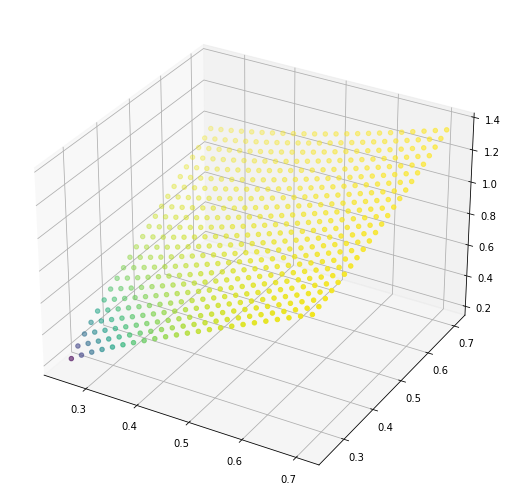

In [22]:

import matplotlib.pyplot as plt

fig = plt.figure(figsize = [9,9])
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xv,yv,zv,c=kall)

In [48]:
np.max(np.abs((kall_analytic.flatten()- kall.flatten()))),np.mean(np.abs((kall_analytic.flatten()- kall.flatten()))),np.std(np.abs((kall_analytic.flatten()- kall.flatten())))

(4.960534039089026e-07, 5.249217911395337e-08, 6.301722872340267e-08)

Text(0, 0.5, 'Error Curvature')

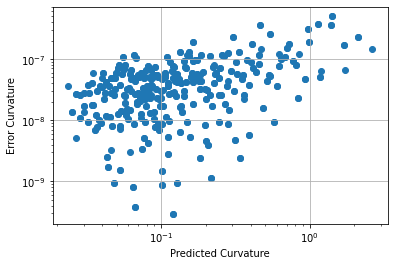

In [56]:
plt.scatter(np.abs(kall.flatten()),np.abs(kall_analytic.flatten()- kall.flatten()))#,bins=40)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('Predicted Curvature')
plt.ylabel('Error Curvature')

Text(0, 0.5, 'Error Curvature/Curvature')

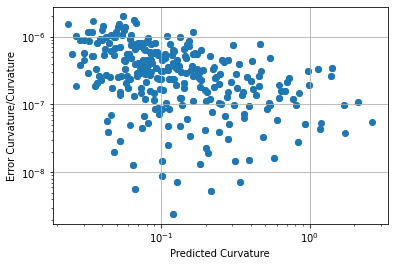

In [59]:
plt.scatter(np.abs(kall.flatten()),np.abs(kall_analytic.flatten()- kall.flatten())/np.abs(kall.flatten()))#,bins=40)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('Predicted Curvature')
plt.ylabel('Error Curvature/Curvature')

(array([ 8.,  2.,  2., 13.,  6.,  8., 16., 12.,  8., 24., 25., 30., 29.,
        35., 43., 44., 33., 37., 26., 21., 16., 18., 10.,  8.,  4., 12.,
         6.,  6.,  0.,  8.,  3.,  0.,  6.,  2.,  3.,  0.,  1.,  2.,  0.,
         2.]),
 array([-1.05464615e-06, -9.78782935e-07, -9.02919716e-07, -8.27056498e-07,
        -7.51193279e-07, -6.75330060e-07, -5.99466841e-07, -5.23603622e-07,
        -4.47740403e-07, -3.71877184e-07, -2.96013966e-07, -2.20150747e-07,
        -1.44287528e-07, -6.84243091e-08,  7.43890976e-09,  8.33021286e-08,
         1.59165347e-07,  2.35028566e-07,  3.10891785e-07,  3.86755004e-07,
         4.62618223e-07,  5.38481442e-07,  6.14344661e-07,  6.90207879e-07,
         7.66071098e-07,  8.41934317e-07,  9.17797536e-07,  9.93660755e-07,
         1.06952397e-06,  1.14538719e-06,  1.22125041e-06,  1.29711363e-06,
         1.37297685e-06,  1.44884007e-06,  1.52470329e-06,  1.60056651e-06,
         1.67642972e-06,  1.75229294e-06,  1.82815616e-06,  1.90401938e-06,
      

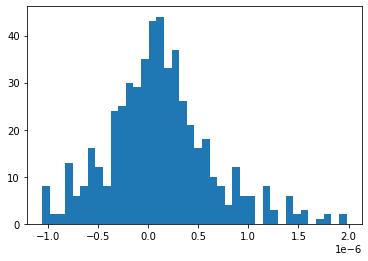

In [49]:
plt.hist((kall_analytic.flatten()- kall.flatten())/kall.flatten(),bins=40)

Text(0, 0.5, 'Numerical calculation of curvature')

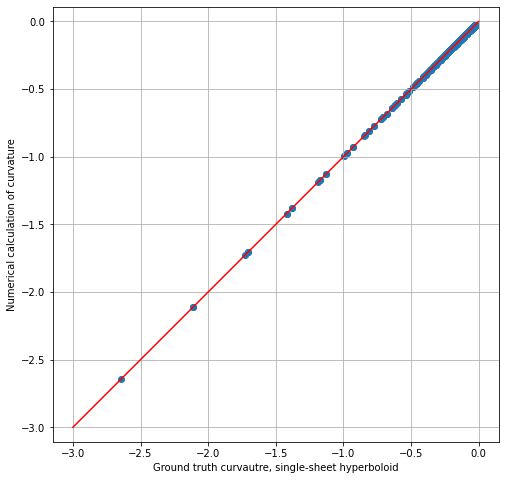

In [30]:
plt.figure(figsize=[8,8])
plt.scatter(kall_analytic.flatten(), kall)
plt.plot([-3,0],[-3,0],'r')
plt.axis('equal')
plt.grid()
plt.xlabel('Ground truth curvautre, single-sheet hyperboloid')
plt.ylabel('Numerical calculation of curvature')
# plt.ylim([-.00003,.00003])

In [28]:
# %matplotlib notebook

Text(0, 0.5, 'Numerical calculation of curvature')

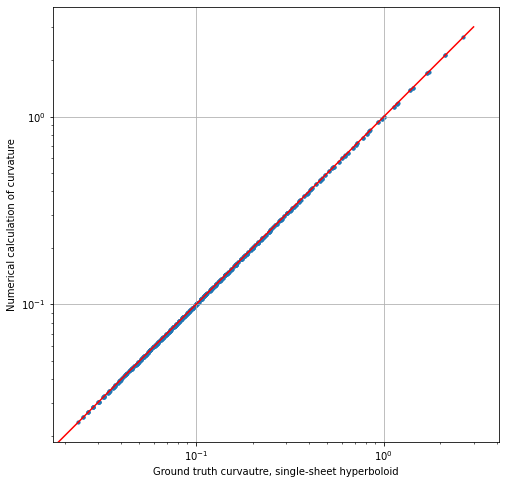

In [40]:
plt.figure(figsize=[8,8])
plt.plot([0,3],[0,3],'r')
plt.scatter(np.abs(kall_analytic.flatten()), np.abs(kall),s=10,marker='o')
# plt.
plt.axis('equal')
plt.grid()
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Ground truth curvautre, single-sheet hyperboloid')
plt.ylabel('Numerical calculation of curvature')
# plt.ylim([-.00003,.00003])

In [95]:
def curvature_highdim(ygrad,yhess):    

    sx = np.zeros([len(ygrad),len(ygrad)+1])
    sxeye = np.eye(len(ygrad))

    sx[:len(ygrad),:len(ygrad)]=sxeye
    sx[:,len(ygrad)]=ygrad
    print(sx)

    V =  np.eye(len(ygrad))
    xv = ygrad
    sn0 = np.matmul(V,xv)
    sn = np.zeros(np.shape(sn0)[0]+1)
    sn[:-1]=sn0
    sn[-1]=-1
    C = sn/np.linalg.norm(sn)
    print(C,sn)
    FF = np.matmul(sx,sx.T)
#     FF=np.outer(ygrad,ygrad)
    print('ff',FF)

    print('out',np.outer(ygrad,ygrad))
    SF = np.zeros_like(FF)
    for ii in range(len(ygrad)):
        for jj in range(len(ygrad)):
            zvec = np.zeros([len(ygrad)+1,1])
            zvec[-1]=yhess[ii,jj]
            SF[ii,jj]=np.matmul(zvec[:,0],C)
    print(SF)
    SO = np.linalg.lstsq(FF,SF,rcond=None)[0]
#         SO = np.matmul(np.linalg.inv(I),II)#[0]
    SOnan = np.max(np.isnan(SO).flatten())
#         kd,KM=np.linalg.eig(SO);
    kd=np.linalg.eigvals(SO);
#         kall.append(kd[0]*kd[1])
    kall=kd[0]*kd[1]
    
    return kall, SO, FF, SF

In [96]:
xi,yi=12,12

In [97]:
kallhd, SO, FF, SF = curvature_highdim(ygrad[xi,yi,:],np.reshape(yhess[xi,yi,:],[2,2]))

[[1.         0.         1.11803401]
 [0.         1.         1.11803401]]
[ 0.59761431  0.59761431 -0.53452248] [ 1.11803401  1.11803401 -1.        ]
ff [[2.25000004 1.25000004]
 [1.25000004 2.25000004]]
out [[1.25000004 1.25000004]
 [1.25000004 1.25000004]]
[[-0.44821068  0.74701793]
 [ 0.74701793 -0.44821068]]


In [93]:
FF

array([[1.25000004, 1.25000004],
       [1.25000004, 1.25000004]])

In [94]:
kallhd,kall_analytic[xi,yi],kall[xi,yi]

(0.0, -0.10204081632653063, -0.10204084768238116)

In [97]:
kallhd

-0.10204084768238089

In [94]:
kall_analytic[12,12]

-0.10204081632653063

In [ ]:

[[0.4482106825905703, -0.7470179317577069], [-0.7470179317577069, 0.4482106825905703]]

In [92]:
.83852541*.7470179317/1.3975426 

0.4482106788416285

In [39]:
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
# import matplotlib.pyplot as plt

# # %matplotlib notebook
# # %matplotlib notebook
# fig = plt.figure(figsize = [9,9])

# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(xv.flatten(),yv.flatten(),zv.flatten(),c=zv.flatten())

In [ ]:
# ####### MATLAB

# [x1v x2v x3v] =meshgrid(-endp:intp:endp,-endp:intp:endp,-endp:intp:endp);
# x1 = x1v(:); x2 = x2v(:); x3 = x3v(:);

# sx1_1 = ones(size(x1)); sx1_2 = zeros(size(x1)); sx1_3 = zeros(size(x1)); 
# sx2_1 = zeros(size(x2)); sx2_2 = ones(size(x2)); sx2_3 = zeros(size(x2)); 
# sx3_1 = zeros(size(x3)); sx3_2 = zeros(size(x3)); sx3_3 = ones(size(x3)); 

# myfun = ADfun('surfgen3d',1);
# for ind1 = 1:length(x1)
# [f, g, H] = feval(myfun,[x1(ind1) x2(ind1) x3(ind1) ]);
# fout(ind1) = f;
# grad(ind1,:) = g(:);

# hess(ind1,:) = H(:);

# end
# szx1 = grad(:,1);
# szx2 = grad(:,2);
# szx3 = grad(:,3);
# %  
# szx1_1 = hess(:,1); szx1_2 = hess(:,2); szx1_3 = hess(:,3); 
# szx2_1 = hess(:,4); szx2_2 = hess(:,5); szx2_3 = hess(:,6); 
# szx3_1 = hess(:,7); szx3_2 = hess(:,8); szx3_3 = hess(:,9); 

# sx1(:,1)=sx1_1; sx2(:,1)=sx1_2; sx3(:,1)=sx1_3; 
# sx1(:,2)=sx2_1; sx2(:,2)=sx2_2; sx3(:,2)=sx2_3; 
# sx1(:,3)=sx3_1; sx2(:,3)=sx3_2; sx3(:,3)=sx3_3; 

# sx1(:,4)=szx1;
# sx2(:,4)=szx2;
# sx3(:,4)=szx3;

# for ind1 = 1:length(x1)
# v1(1:4) = sx1(ind1,:);
# v2(1:4) = sx2(ind1,:);
# v3(1:4) = sx3(ind1,:);
# V = [v1(1:3); v2(1:3); v3(1:3)];
# xv = [v1(4); v2(4); v3(4)];
# sn = (V)*xv; sn(4) = -1;
# C(ind1,:) = sn./norm(sn);
# end
# nanctr = 0;

# for ind1 = 1:length(x1)

# FF =[dot(sx1(ind1,:), sx1(ind1,:)) dot(sx1(ind1,:), sx2(ind1,:)) dot(sx1(ind1,:), sx3(ind1,:)) ;...
# dot(sx2(ind1,:), sx1(ind1,:)) dot(sx2(ind1,:), sx2(ind1,:)) dot(sx2(ind1,:), sx3(ind1,:)) ;...
# dot(sx3(ind1,:), sx1(ind1,:)) dot(sx3(ind1,:), sx2(ind1,:)) dot(sx3(ind1,:), sx3(ind1,:)) ;...
# ];
# Cvect(1,:) = C(ind1,:); 
# SF =[dot([0,0,0,szx1_1(ind1)], Cvect) dot([0,0,0,szx1_2(ind1)], Cvect) dot([0,0,0,szx1_3(ind1)], Cvect) ;...
#  dot([0,0,0,szx2_1(ind1)], Cvect) dot([0,0,0,szx2_2(ind1)], Cvect) dot([0,0,0,szx2_3(ind1)], Cvect) ;...
#  dot([0,0,0,szx3_1(ind1)], Cvect) dot([0,0,0,szx3_2(ind1)], Cvect) dot([0,0,0,szx3_3(ind1)], Cvect) ;...
#  ];
# SO=FF\SF;
# % SO = FF'*SF*FF

In [25]:
myvalue

array([[0.2236068 , 0.26777115, 0.30844593, 0.34686092, 0.38369548,
        0.41936625, 0.45414755, 0.48822951, 0.52174919, 0.55480853,
        0.58748522, 0.61983981, 0.65192024, 0.68376511, 0.71540587,
        0.74686846, 0.7781745 , 0.80934215, 0.84038682, 0.87132163,
        0.90215791, 0.93290541, 0.96357263],
       [0.26777115, 0.30561868, 0.34181907, 0.3768473 , 0.41100318,
        0.44448785, 0.47744255, 0.50997004, 0.54214722, 0.574033  ,
        0.60567341, 0.637105  , 0.66835723, 0.69945415, 0.7304156 ,
        0.7612581 , 0.79199555, 0.82263972, 0.85320067, 0.88368704,
        0.91410627, 0.94446487, 0.97476849],
       [0.30844593, 0.34181907, 0.37453675, 0.40675716, 0.43858991,
        0.47011376, 0.50138697, 0.5324537 , 0.56334813, 0.59409712,
        0.62472216, 0.65524063, 0.68566675, 0.7160123 , 0.74628711,
        0.77649945, 0.80665634, 0.83676377, 0.86682691, 0.8968502 ,
        0.92683751, 0.95679224, 0.98671734],
       [0.34686092, 0.3768473 , 0.40675716, 0.436

In [28]:
all_variables = dir()
  
# Iterate over the whole list where dir( )
# is stored.
for name in all_variables:

    
    # Print the item if it doesn't start with '__'
    if not name.startswith('__'):
        myvalue = eval(name)
#         print(type(myvalue))
        if type(myvalue) is 'numpy.ndarray':
            print(myvalue[0])
#         print('\n',name, "is", type(myvalue), "and is equal to ", myvalue)